<a href="https://colab.research.google.com/github/sayid-alt/kulitku-bangkit2024/blob/main/Machine%20Learning/skin_type/skin_type_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Libarary

In [29]:
!pip install keras-tuner --upgrade

import zipfile
import os
import shutil
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import keras_tuner
import keras

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from google.colab import files

import datetime


# Download data from kaggle

In [2]:
!pip install kaggle
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sayidheykal","key":"e6e9a20922c6182e48e1cbac69a56342"}'}

In [30]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d shakyadissanayake/oily-dry-and-normal-skin-types-dataset

Dataset URL: https://www.kaggle.com/datasets/shakyadissanayake/oily-dry-and-normal-skin-types-dataset
License(s): Apache 2.0
 92% 114M/124M [00:01<00:00, 60.5MB/s]
100% 124M/124M [00:01<00:00, 69.7MB/s]
mv: cannot stat 'kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/shakyadissanayake/oily-dry-and-normal-skin-types-dataset
License(s): Apache 2.0
oily-dry-and-normal-skin-types-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


# Utilities

In [31]:
def move_files(source_dir, destination_dir):
    # Ensure the source and destination directories exist
    if not os.path.exists(source_dir):
        print(f"The source directory '{source_dir}' does not exist.")
        return

    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)
        print(f"Created the destination directory '{destination_dir}'.")

    # List all files in the source directory
    files = os.listdir(source_dir)

    # Loop through all files and move them to the destination directory
    sum = 0
    for file_name in files:
        # Construct full file path
        source_file = os.path.join(source_dir, file_name)
        destination_file = os.path.join(destination_dir, file_name)

        # Move the file
        shutil.move(source_file, destination_file)
        sum+=1

    print(f'successfully moved {sum} files from {source_dir} to {destination_dir}')



def unzip_file(zip_path, extract_to='.'):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

def create_directory(path):
    try:
        os.makedirs(path, exist_ok=True)
        print(f"Directory '{path}' created successfully.")
    except Exception as e:
        print(f"Error creating directory '{path}': {e}")



def count_files_and_directories(path):
    file_count = 0
    directory_count = 0

    for dirpath, dirnames, filenames in os.walk(path):
        # Count the number of files in the current directory
        file_count += len(filenames)
        # Count the number of subdirectories in the current directory
        directory_count += len(dirnames)

    return file_count, directory_count


def convert_keras_to_tflite(keras_model_path, tflite_model_path):
    # Load the TensorFlow model
    converter = tf.lite.TFLiteConverter.from_keras_model(keras_model_path)

    # Convert the model to TFLite format
    tflite_model = converter.convert()

    # Save the converted model to a file
    with open(tflite_model_path, 'wb') as f:
        f.write(tflite_model)

    print(f"Model converted and saved to {tflite_model_path}")


def plot_portion(values, labels, title='Portion of values'):
  fig, ax = plt.subplots()

  sum_values = sum(values)
  percentages = [value / sum_values for value in values]

  bar_colors = ['tab:red', 'tab:blue', 'tab:orange']

  # Create horizontal bar chart
  bars = ax.bar(labels, values, color=bar_colors, label=labels)

  # Add labels to bars with customizations
  ax.bar_label(bars, labels=[f'{round(v * 100, 2)} %' for v in percentages], padding=3, fontsize=10, label_type='center')

  # Set labels
  ax.set_ylabel('values')
  ax.set_title(title)
  ax.legend(title='categories')

  # Show the plot
  plt.show()

def plot_acc_loss(history):
  plt.figure(figsize=(12, 4))

  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')

  # Plot training & validation loss values
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')

  # save graph to png
  pngfile = 'acc_loss.png'
  if os.path.isfile(pngfile):
    plt.savefig('acc_loss(1).png')
  plt.savefig(f'acc_loss.png')

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  print(f'accuracy\t: {acc[len(acc)-1]}, val_accuracy\t: {val_acc[len(val_acc)-1]}')

  print(f'loss\t\t: {loss[len(loss)-1]}, val_loss\t: {val_loss[len(val_loss)-1]}')


def move_files_after_split(X, y, base_dir):
  sum = 0
  for source_dir, category in zip(X, y):
    filename = source_dir.split('/')[-1]
    destination_dir = os.path.join(base_dir, category, filename)
    shutil.move(source_dir, destination_dir)
    sum+= 1
  print(f'successfully moved {sum} files to {destination_dir}')

def checking_dir_qty(base_dir, train_dir, valid_dir, test_dir):
  num_train, num_train_labels = count_files_and_directories(train_dir)
  num_valid, num_valid_labels = count_files_and_directories(valid_dir)
  num_test, num_test_labels = count_files_and_directories(test_dir)

  all, _ = count_files_and_directories(base_dir)

  print(f'number of images: {all}\n-------------------\n')
  print(f'train data length: {num_train}\nNum of train labels: {num_train_labels}\npercentage: {round(num_train/all*100,2)} %\n')
  print(f'valid data length: {num_valid}\nNum of train labels: {num_valid_labels}\npercentage: {round(num_valid/all*100,2)} %\n')
  print(f'test data length: {num_test}\nNum of test labels: {num_test_labels}\npercentage: {round(num_test/all*100,2)} %\n')

def zip_directory(directory_path, zip_path):
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(directory_path):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, start=directory_path)
                zipf.write(file_path, arcname=arcname)

    print(f'successfull zipping {directory_path} to {zip_path}')





In [32]:
dataset_dir = '/content/oily-dry-and-normal-skin-types-dataset'
if os.path.isdir(dataset_dir):
  shutil.rmtree(dataset_dir)

# Unzip dataset
zip_path = dataset_dir + '.zip'
unzip_file(zip_path)

# Generate data

In [33]:
# defined directories
# -------------------

# base working directory
base_dir = '/content/Oily-Dry-Skin-Types/'

# training data directory
train_dir = base_dir + 'train'

 # validation data directory
valid_dir = base_dir + 'valid'

# test data directory
test_dir = base_dir + 'test'

train_dir, valid_dir, test_dir

('/content/Oily-Dry-Skin-Types/train',
 '/content/Oily-Dry-Skin-Types/valid',
 '/content/Oily-Dry-Skin-Types/test')

('/content/Oily-Dry-Skin-Types/train',
 '/content/Oily-Dry-Skin-Types/valid',
 '/content/Oily-Dry-Skin-Types/test')

## Gathering all picture to one folder as their categories

In [34]:
checking_dir_qty(base_dir, train_dir, valid_dir, test_dir)

number of images: 3153
-------------------

train data length: 2756
Num of train labels: 3
percentage: 87.41 %

valid data length: 262
Num of train labels: 3
percentage: 8.31 %

test data length: 134
Num of test labels: 3
percentage: 4.25 %

number of images: 4049
-------------------

train data length: 3069
Num of train labels: 3
percentage: 75.8 %

valid data length: 721
Num of train labels: 3
percentage: 17.81 %

test data length: 258
Num of test labels: 3
percentage: 6.37 %



In [35]:
# define class names as a label
categories = [name for name in os.listdir(train_dir)]
categories

['oily', 'dry', 'normal']

['oily', 'dry', 'normal']

In [36]:
# create dicertories for all existing data
all_dir = os.path.join(base_dir, 'all')

for cat in categories:
  create_directory(os.path.join(all_dir, cat))

# move all images to the all directory as a default before splitted
for dirname in [train_dir, valid_dir, test_dir]:
  for cat in categories:
    source_dir = os.path.join(dirname, cat)
    destination_dir = os.path.join(all_dir, cat)
    move_files(source_dir, destination_dir)


Directory '/content/Oily-Dry-Skin-Types/all/oily' created successfully.
Directory '/content/Oily-Dry-Skin-Types/all/dry' created successfully.
Directory '/content/Oily-Dry-Skin-Types/all/normal' created successfully.
successfully moved 1000 files from /content/Oily-Dry-Skin-Types/train/oily to /content/Oily-Dry-Skin-Types/all/oily
successfully moved 652 files from /content/Oily-Dry-Skin-Types/train/dry to /content/Oily-Dry-Skin-Types/all/dry
successfully moved 1104 files from /content/Oily-Dry-Skin-Types/train/normal to /content/Oily-Dry-Skin-Types/all/normal
successfully moved 80 files from /content/Oily-Dry-Skin-Types/valid/oily to /content/Oily-Dry-Skin-Types/all/oily
successfully moved 71 files from /content/Oily-Dry-Skin-Types/valid/dry to /content/Oily-Dry-Skin-Types/all/dry
successfully moved 111 files from /content/Oily-Dry-Skin-Types/valid/normal to /content/Oily-Dry-Skin-Types/all/normal
successfully moved 40 files from /content/Oily-Dry-Skin-Types/test/oily to /content/Oily-

# EDA

Checking All data in test, train, valid folder (should be empty)

In [37]:
checking_dir_qty(base_dir, train_dir, valid_dir, test_dir)

number of images: 3153
-------------------

train data length: 0
Num of train labels: 3
percentage: 0.0 %

valid data length: 0
Num of train labels: 3
percentage: 0.0 %

test data length: 0
Num of test labels: 3
percentage: 0.0 %

number of images: 3153
-------------------

train data length: 0
Num of train labels: 3
percentage: 0.0 %

valid data length: 0
Num of train labels: 3
percentage: 0.0 %

test data length: 0
Num of test labels: 3
percentage: 0.0 %



## Look up the quantities of the category directory

oily : 1120
dry : 758
normal : 1274


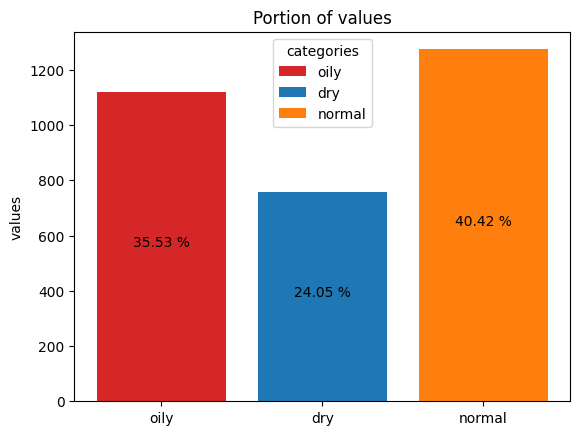

oily : 1120
dry : 758
normal : 1274


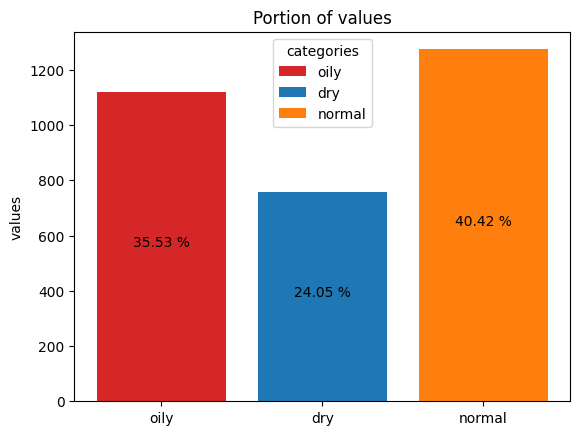

In [38]:
values = []
for i, class_name in enumerate(categories):
  class_length = len(os.listdir(os.path.join(all_dir, class_name)))
  values.append(class_length)
  print(f'{class_name} : {class_length}')

plot_portion(values, categories)

## Data Distribution

(array([1., 0., 2.]),
 array([ 758.,  930., 1102., 1274.]),
 <BarContainer object of 3 artists>)

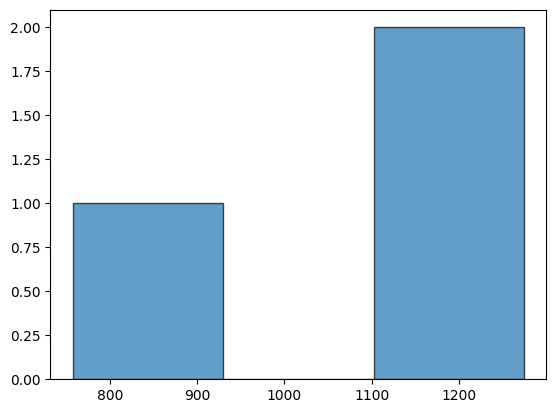

(array([1., 0., 2.]),
 array([ 758.,  930., 1102., 1274.]),
 <BarContainer object of 3 artists>)

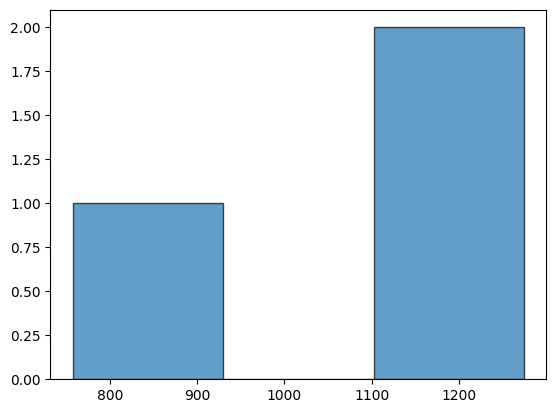

In [39]:
plt.hist(values, bins=3, alpha=0.7, edgecolor='black')

# Data Preprocessing

In [40]:
count_files_and_directories('/content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/all')

(0, 0)

(0, 0)

In [41]:
images, category = [], []
for cat in categories:
  path_cat = os.listdir(os.path.join(all_dir, cat))
  for image in path_cat:
    images.append(os.path.join(all_dir, cat, image))
    category.append('dry' if cat == 'dry' else 'normal' if cat == 'normal' else 'oily')


df = pd.DataFrame({'images':images, 'category':category})
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.iloc[77]['images'].split('/')[-1]

'dry_12161204e3915bc8f99d_jpg.rf.2fe97a7064247847eaa463761388baf7.jpg'

'dry_12161204e3915bc8f99d_jpg.rf.2fe97a7064247847eaa463761388baf7.jpg'

## Split data

In [42]:
# Split Train and validation set
X_train, X_valid, y_train, y_valid = train_test_split(df['images'], df['category'],
                                                      test_size=0.2, random_state=42,
                                                      stratify=df['category'])

# Split validation set for test set
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.2,
                                                    random_state=42, stratify=y_valid)

train: 2521
valid: 504
X_test : 127


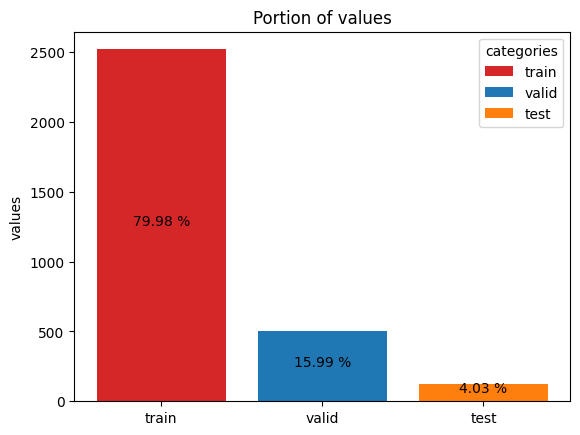

train: 2521
valid: 504
X_test : 127


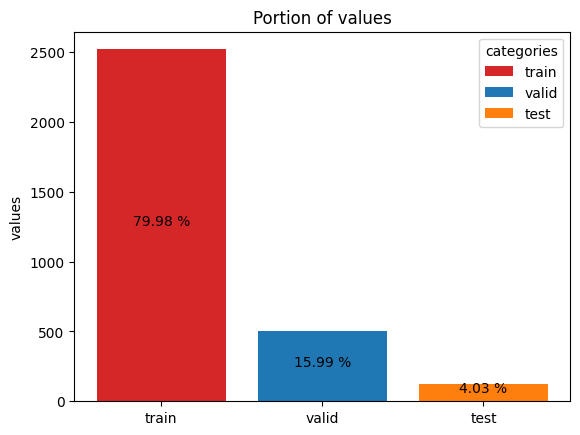

In [43]:
# check qty of split
print(f'train: {len(X_train)}\nvalid: {len(X_valid)}\nX_test : {len(X_test)}')
plot_portion(values=[len(X_train), len(X_valid), len(X_test)], labels=['train', 'valid', 'test'])

In [44]:
# Moving a train files to train directory
move_files_after_split(X_train, y_train, train_dir)
move_files_after_split(X_valid, y_valid, valid_dir)
move_files_after_split(X_test, y_test, test_dir)

successfully moved 2521 files to /content/Oily-Dry-Skin-Types/train/dry/dry_49ede6b7f1fc2cf58c1f_jpg.rf.46c1fd4ca656649d811c467e98024dac.jpg
successfully moved 504 files to /content/Oily-Dry-Skin-Types/valid/oily/oily_48ea6fb7bb774349b7d9_jpg.rf.bde571a71e9c520f330ec0aa519c88e9.jpg
successfully moved 127 files to /content/Oily-Dry-Skin-Types/test/dry/dry_d197914e018991c5a570_jpg.rf.c6e1ff85f8caefc1ee726e9b66a008a6.jpg
successfully moved 2521 files to /content/Oily-Dry-Skin-Types/train/dry/dry_49ede6b7f1fc2cf58c1f_jpg.rf.46c1fd4ca656649d811c467e98024dac.jpg
successfully moved 504 files to /content/Oily-Dry-Skin-Types/valid/oily/oily_48ea6fb7bb774349b7d9_jpg.rf.bde571a71e9c520f330ec0aa519c88e9.jpg
successfully moved 127 files to /content/Oily-Dry-Skin-Types/test/dry/dry_d197914e018991c5a570_jpg.rf.c6e1ff85f8caefc1ee726e9b66a008a6.jpg


In [45]:
# Check if the images from (all) category is moved
count_files_and_directories(os.path.join(base_dir, 'all'))

(0, 3)

(0, 3)

In [46]:
# Check if the images is moved as a split portion
print(count_files_and_directories(os.path.join(base_dir, 'test'))) # return len of (files, directories)
print(count_files_and_directories(os.path.join(base_dir, 'train')))# return len of (files, directories
print(count_files_and_directories(os.path.join(base_dir, 'valid')))# return len of (files, directories

(127, 3)
(2521, 3)
(504, 3)
(127, 3)
(2521, 3)
(504, 3)


# Download splitted dataset

In [47]:
# remove temp file -(all) category-
shutil.rmtree(os.path.join(base_dir, 'all'))

## Zipping splitted dataset file

In [48]:
directory_path = base_dir
zip_path = 'skin-type-dataset.zip'
zip_directory(directory_path, zip_path)
print(f"Directory '{directory_path}' has been zipped as '{zip_path}'")

successfull zipping /content/Oily-Dry-Skin-Types/ to skin-type-dataset.zip
Directory '/content/Oily-Dry-Skin-Types/' has been zipped as 'skin-type-dataset.zip'
successfull zipping /content/Oily-Dry-Skin-Types/ to skin-type-dataset.zip
Directory '/content/Oily-Dry-Skin-Types/' has been zipped as 'skin-type-dataset.zip'


# Generate Data (after split 80/15/5)

In [49]:
# Unzip dataset
zip_path = '/content/skin-type-dataset.zip'
dataset_path = '/content/skin_type_dataset'

if os.path.isdir(dataset_path):
  shutil.rmtree(dataset_path)

unzip_file(zip_path, extract_to=dataset_path)

In [50]:
# defined directories
# -------------------

# base working directory
base_dir = dataset_path

# remove readme file
readme_file = os.path.join(base_dir, 'README.dataset.txt')
if os.path.isfile(readme_file):
  os.remove(readme_file)

# training data directory
train_dir = os.path.join(base_dir, 'train')

 # validation data directory
valid_dir =os.path.join(base_dir, 'valid')

# test data directory
test_dir = os.path.join(base_dir, 'test')

train_dir, valid_dir, test_dir

('/content/skin_type_dataset/train',
 '/content/skin_type_dataset/valid',
 '/content/skin_type_dataset/test')

('/content/skin_type_dataset/train',
 '/content/skin_type_dataset/valid',
 '/content/skin_type_dataset/test')

## Data generator

In [51]:
# create imageDataGenerator instance
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest'
                                   )
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [52]:
# create Generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224,224),
                                                    batch_size=32,
                                                    class_mode='categorical'
                                                    )

validation_generator = validation_datagen.flow_from_directory(valid_dir,
                                                    target_size=(224,224),
                                                    batch_size=32,
                                                    class_mode='categorical'
                                                    )

test_generator = test_datagen.flow_from_directory(test_dir,
                                                    target_size=(224,224),
                                                    batch_size=32,
                                                    class_mode='categorical'
                                                    )

Found 2521 images belonging to 3 classes.
Found 504 images belonging to 3 classes.
Found 127 images belonging to 3 classes.
Found 2521 images belonging to 3 classes.
Found 504 images belonging to 3 classes.
Found 127 images belonging to 3 classes.


In [53]:
train_generator.class_indices

{'dry': 0, 'normal': 1, 'oily': 2}

{'dry': 0, 'normal': 1, 'oily': 2}

# Data Visualitaion

In [54]:
split_names = ['train','valid', 'test']
num_train, _ = count_files_and_directories(train_dir)
num_valid, _ = count_files_and_directories(valid_dir)
num_test, _ = count_files_and_directories(test_dir)
values = [num_train, num_valid, num_test]

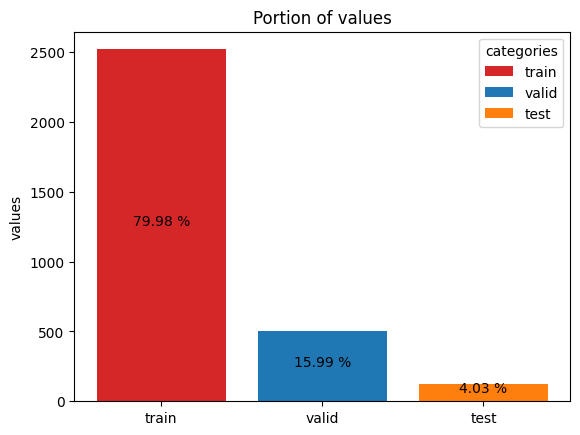

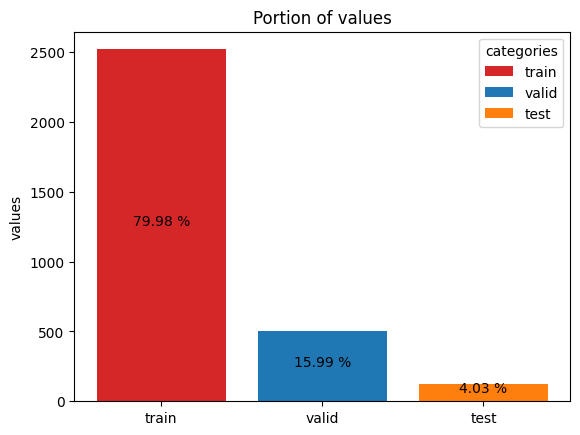

In [55]:
plot_portion(values, split_names)

# Build model

In [ ]:
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94668760/94668760 [==============================] - 5s 0us/step


In [ ]:
def build_model(hp):
  x = base_model.output

  if hp.Boolean("flatten"):
      x = Flatten()(x)
  elif hp.Boolean("global_average_pooling"):
      x = GlobalAveragePooling2D()(x)

  # Tune whether to use dropout.
  if hp.Boolean("dropout"):
      x = Dropout(rate=0.25)(x)

  x = Dense(
        # Tune number of units.
        units=hp.Int("units", min_value=32, max_value=1024, step=32),
        activation='relu')(x)

  # Tune whether to use dropout.
  if hp.Boolean("dropout"):
      x = Dropout(rate=0.25)(x)

  x = Dense(
        # Tune number of units.
        units=hp.Int("units", min_value=32, max_value=512, step=32),
        activation='relu')(x)

  if hp.Boolean("batch_normalization"):
    x = BatchNormalization()(x)

  predictions = Dense(3, activation='softmax')(x)

  # Create model
  model = Model(inputs=base_model.input, outputs=predictions)

  # Define the optimizer learning rate as a hyperparameter.
  learning_rate = hp.Float("learning_rate", min_value=1e-6, max_value=1e-2, sampling="log")

  # Define learning rate scheduler
  lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

  model.compile(optimizer=Adam(learning_rate=lr_schedule),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return model

# create a model
model = build_model(keras_tuner.HyperParameters())
model

## Hyperparameter tuning

In [ ]:
# define tuner using RandomSearch
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=5,
    executions_per_trial=2,
    overwrite=False,
    directory="/content/keras_tuner/",
    project_name="skin_type_model",
)

# print search space summary
tuner.search_space_summary()

Search space summary
Default search space size: 6
flatten (Boolean)
{'default': False, 'conditions': []}
global_average_pooling (Boolean)
{'default': False, 'conditions': []}
dropout (Boolean)
{'default': False, 'conditions': []}
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 1024, 'step': 32, 'sampling': 'linear'}
batch_normalization (Boolean)
{'default': False, 'conditions': []}
learning_rate (Float)
{'default': 1e-06, 'conditions': [], 'min_value': 1e-06, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [ ]:
# start search best parameters
tuner.search(train_generator, epochs=2, validation_data=validation_generator)

Trial 5 Complete [00h 03m 07s]
val_accuracy: 0.417658731341362

Best val_accuracy So Far: 0.6805555820465088
Total elapsed time: 00h 12m 59s


## Query Result

In [ ]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]

In [ ]:
best_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                              

In [ ]:
best_model.save('best_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
tuner.results_summary()

In [ ]:
!zip -r /content/skin_type_model.zip /content/keras_tuner/skin_type_model

In [ ]:
# files.download('/content/skin_type_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Retrain Models

### Set Callbacks

In [56]:
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/ckpt/model_{epoch:02d}_{accuracy:.2f}_{val_accuracy:.2f}_v02.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

backup_restore = keras.callbacks.BackupAndRestore(backup_dir="/tmp/backup")

csv_logger = tf.keras.callbacks.CSVLogger(f'/content/csv_logger.csv')

In [61]:
import requests

def train_model(epochs, steps_per_epoch, tuner=None, unfreeze=None, callbacks=None):
  # Get the top 2 hyperparameters.
  # best_hps = tuner.get_best_hyperparameters(5)


  # Build the model with the best hp.
  url = 'https://github.com/sayid-alt/kulitku-bangkit2024/raw/main/Machine%20Learning/skin_type/best_model.h5'
  model_path = 'best_model.h5'

  response = requests.get(url)
  with open(model_path, 'wb') as f:
    f.write(response.content)

  model = tf.keras.models.load_model(model_path)

  # # freeze some layers and
  # for layer in base_model.layers:
  #   layer.trainable = False

  # if unfreeze is not None:
  #   # unfreeze some layers
  #   for layer in base_model.layers[-unfreeze:]:
  #     layer.trainable = True
  model.summary()
  history = model.fit(train_generator, epochs=epochs,
            batch_size=32,
            verbose=2,
            steps_per_epoch=steps_per_epoch,
            validation_data=validation_generator,
            validation_steps=validation_generator.samples // validation_generator.batch_size,
            callbacks=[callbacks])

  return history

In [62]:
EPOCHS = 50
steps_per_epoch = train_generator.samples // train_generator.batch_size
callbacks = [ckpt_callback, csv_logger]

In [ ]:

history = train_model(epochs=EPOCHS,
                      steps_per_epoch=steps_per_epoch,
                      callbacks=callbacks)

Epoch 1/50
78/78 - 72s - loss: 1.0257 - accuracy: 0.5344 - val_loss: 1.0995 - val_accuracy: 0.6042 - 72s/epoch - 928ms/step
Epoch 2/50
78/78 - 38s - loss: 0.8173 - accuracy: 0.6396 - val_loss: 0.8387 - val_accuracy: 0.6812 - 38s/epoch - 494ms/step
Epoch 3/50
78/78 - 38s - loss: 0.6945 - accuracy: 0.7051 - val_loss: 0.6785 - val_accuracy: 0.7437 - 38s/epoch - 490ms/step
Epoch 4/50
78/78 - 33s - loss: 0.5631 - accuracy: 0.7730 - val_loss: 0.6971 - val_accuracy: 0.7437 - 33s/epoch - 418ms/step
Epoch 5/50
78/78 - 40s - loss: 0.4981 - accuracy: 0.7995 - val_loss: 0.6472 - val_accuracy: 0.7604 - 40s/epoch - 516ms/step
Epoch 6/50
78/78 - 39s - loss: 0.4383 - accuracy: 0.8260 - val_loss: 0.5477 - val_accuracy: 0.8208 - 39s/epoch - 496ms/step
Epoch 7/50
78/78 - 32s - loss: 0.3690 - accuracy: 0.8566 - val_loss: 0.6311 - val_accuracy: 0.7875 - 32s/epoch - 416ms/step
Epoch 8/50
78/78 - 38s - loss: 0.3205 - accuracy: 0.8767 - val_loss: 0.6146 - val_accuracy: 0.8229 - 38s/epoch - 486ms/step
Epoch 9/

# Evaluation

## Download best model after retrained

In [ ]:
model_retrained_path = '/content/ckpt/model_25_0.96_0.90_v02.keras'

# # uncomment for download
# files.download(model_retrained_path)

In [ ]:
# Load saved Model from checkpoint
model_retrained = tf.keras.models.load_model(model_retrained_path)

In [ ]:
# evaluate on test images
val_loss, val_accuracy = model_retrained.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')


3/3 [==============================] - 2s 110ms/step - loss: 0.6584 - accuracy: 0.8958
Validation Loss: 0.6583824753761292
Validation Accuracy: 0.8958333134651184


accuracy	: 0.9682603478431702, val_accuracy	: 0.862500011920929
loss		: 0.09517085552215576, val_loss	: 0.7495971918106079


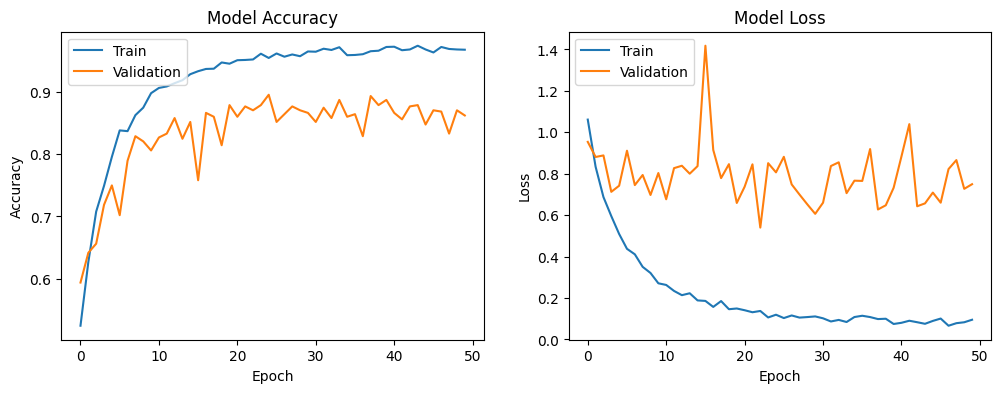

In [ ]:
# Plot training & validation accuracy values
plot_acc_loss(history)

## Visualize the correctly predicted

1/1 [==============================] - 2s 2s/step


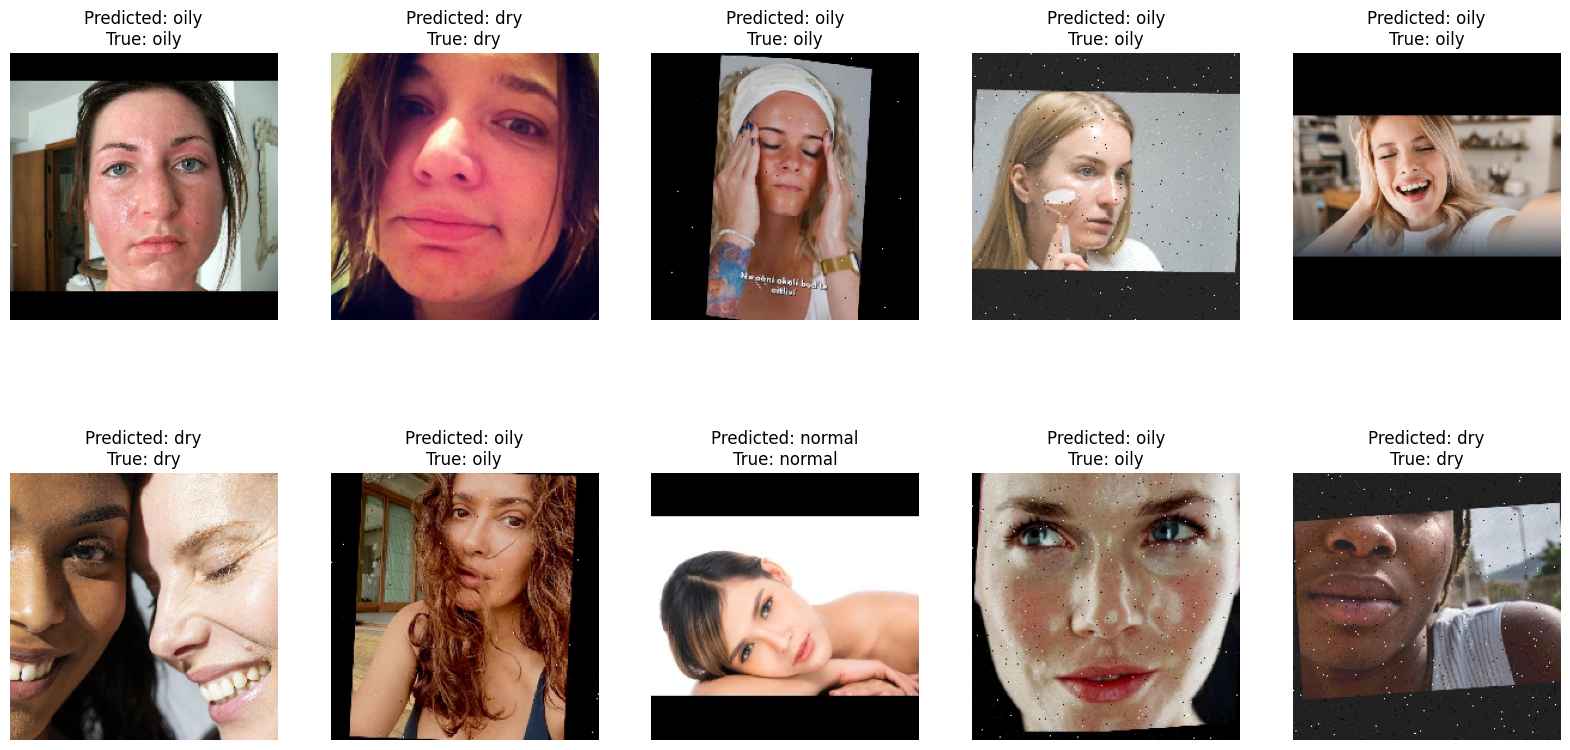

In [ ]:
# Get the class indices
class_indices = test_generator.class_indices
class_labels = {v: k for k, v in class_indices.items()}

# Get a batch of images and labels
images, labels = next(test_generator)

# Predict using the model
predictions = model_retrained.predict(images)

# Get the predicted class indices
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(labels, axis=1)

# Find correctly predicted images
correct_indices = np.where(predicted_classes == true_classes)[0]

# Plot the first 10 correctly predicted images
plt.figure(figsize=(20, 10))
for i, idx in enumerate(correct_indices[:10]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[idx])
    plt.title(f"Predicted: {class_labels[predicted_classes[idx]]}\nTrue: {class_labels[true_classes[idx]]}")
    plt.axis('off')

plt.show()

# Convert model for deployment

## Convert keras model to tflite

In [ ]:
tflite_model_path = 'skin_type_model.tflite'
convert_keras_to_tflite(model_retrained, tflite_model_path)

Model converted and saved to skin_type_model.tflite


## Convert savedModel to tfjs

### Freeze a TensorFlow Model

In [ ]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

infer = model_retrained.signatures['serving_default']

# Convert Keras model to ConcreteFunction
full_model = tf.function(lambda x: infer(x))
concrete_func = full_model.get_concrete_function(tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))

# Convert variables to constants (freeze the model)
frozen_func = convert_variables_to_constants_v2(concrete_func)
frozen_func.graph.as_graph_def()


# Save frozen graph to disk
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir=model_retrained_dir,
                  name="frozen_graph.pb",
                  as_text=False)

'/content/ckpt/model_48_0.94_0.86_v02/frozen_graph.pb'

## TFJS converter

In [ ]:
import tensorflow as tf
import tensorflowjs as tfjs
from tensorflow.keras.layers import BatchNormalization

# Custom layer to replace unsupported operations
class CustomBatchNormalization(BatchNormalization):
    def call(self, inputs, training=False):
        return super().call(inputs, training=training)

# Load the Keras model and replace BatchNormalization layers
# keras_model = tf.keras.models.load_model('/content/ckpt/model_25_0.96_0.90_v02.keras', custom_objects={'post_bn': CustomBatchNormalization})
keras_model = tf.keras.models.load_model('/content/ckpt/model_25_0.96_0.90_v02.keras')


TypeError: Could not deserialize class 'Functional' because its parent module keras.src.engine.functional cannot be imported. Full object config: {'module': 'keras.src.engine.functional', 'class_name': 'Functional', 'config': {'name': 'model_1', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': [None, 224, 224, 3], 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_1'}, 'registered_name': None, 'name': 'input_1', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'conv1_pad', 'trainable': True, 'dtype': 'float32', 'padding': [[3, 3], [3, 3]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 224, 224, 3]}, 'name': 'conv1_pad', 'inbound_nodes': [[['input_1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv1_conv', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [7, 7], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 230, 230, 3]}, 'name': 'conv1_conv', 'inbound_nodes': [[['conv1_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'pool1_pad', 'trainable': True, 'dtype': 'float32', 'padding': [[1, 1], [1, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 64]}, 'name': 'pool1_pad', 'inbound_nodes': [[['conv1_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'pool1_pool', 'trainable': True, 'dtype': 'float32', 'pool_size': [3, 3], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 114, 114, 64]}, 'name': 'pool1_pool', 'inbound_nodes': [[['pool1_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv2_block1_preact_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'conv2_block1_preact_bn', 'inbound_nodes': [[['pool1_pool', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv2_block1_preact_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'conv2_block1_preact_relu', 'inbound_nodes': [[['conv2_block1_preact_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2_block1_1_conv', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'conv2_block1_1_conv', 'inbound_nodes': [[['conv2_block1_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv2_block1_1_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'conv2_block1_1_bn', 'inbound_nodes': [[['conv2_block1_1_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv2_block1_1_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'conv2_block1_1_relu', 'inbound_nodes': [[['conv2_block1_1_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'conv2_block1_2_pad', 'trainable': True, 'dtype': 'float32', 'padding': [[1, 1], [1, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'conv2_block1_2_pad', 'inbound_nodes': [[['conv2_block1_1_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2_block1_2_conv', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 58, 58, 64]}, 'name': 'conv2_block1_2_conv', 'inbound_nodes': [[['conv2_block1_2_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv2_block1_2_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'conv2_block1_2_bn', 'inbound_nodes': [[['conv2_block1_2_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv2_block1_2_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'conv2_block1_2_relu', 'inbound_nodes': [[['conv2_block1_2_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2_block1_0_conv', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'conv2_block1_0_conv', 'inbound_nodes': [[['conv2_block1_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2_block1_3_conv', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'conv2_block1_3_conv', 'inbound_nodes': [[['conv2_block1_2_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'conv2_block1_out', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 56, 56, 256], [None, 56, 56, 256]]}, 'name': 'conv2_block1_out', 'inbound_nodes': [[['conv2_block1_0_conv', 0, 0, {}], ['conv2_block1_3_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv2_block2_preact_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 256]}, 'name': 'conv2_block2_preact_bn', 'inbound_nodes': [[['conv2_block1_out', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv2_block2_preact_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 256]}, 'name': 'conv2_block2_preact_relu', 'inbound_nodes': [[['conv2_block2_preact_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2_block2_1_conv', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 256]}, 'name': 'conv2_block2_1_conv', 'inbound_nodes': [[['conv2_block2_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv2_block2_1_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'conv2_block2_1_bn', 'inbound_nodes': [[['conv2_block2_1_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv2_block2_1_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'conv2_block2_1_relu', 'inbound_nodes': [[['conv2_block2_1_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'conv2_block2_2_pad', 'trainable': True, 'dtype': 'float32', 'padding': [[1, 1], [1, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'conv2_block2_2_pad', 'inbound_nodes': [[['conv2_block2_1_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2_block2_2_conv', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 58, 58, 64]}, 'name': 'conv2_block2_2_conv', 'inbound_nodes': [[['conv2_block2_2_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv2_block2_2_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'conv2_block2_2_bn', 'inbound_nodes': [[['conv2_block2_2_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv2_block2_2_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'conv2_block2_2_relu', 'inbound_nodes': [[['conv2_block2_2_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2_block2_3_conv', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'conv2_block2_3_conv', 'inbound_nodes': [[['conv2_block2_2_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'conv2_block2_out', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 56, 56, 256], [None, 56, 56, 256]]}, 'name': 'conv2_block2_out', 'inbound_nodes': [[['conv2_block1_out', 0, 0, {}], ['conv2_block2_3_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv2_block3_preact_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 256]}, 'name': 'conv2_block3_preact_bn', 'inbound_nodes': [[['conv2_block2_out', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv2_block3_preact_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 256]}, 'name': 'conv2_block3_preact_relu', 'inbound_nodes': [[['conv2_block3_preact_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2_block3_1_conv', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 256]}, 'name': 'conv2_block3_1_conv', 'inbound_nodes': [[['conv2_block3_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv2_block3_1_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'conv2_block3_1_bn', 'inbound_nodes': [[['conv2_block3_1_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv2_block3_1_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'conv2_block3_1_relu', 'inbound_nodes': [[['conv2_block3_1_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'conv2_block3_2_pad', 'trainable': True, 'dtype': 'float32', 'padding': [[1, 1], [1, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'conv2_block3_2_pad', 'inbound_nodes': [[['conv2_block3_1_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2_block3_2_conv', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 58, 58, 64]}, 'name': 'conv2_block3_2_conv', 'inbound_nodes': [[['conv2_block3_2_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv2_block3_2_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 64]}, 'name': 'conv2_block3_2_bn', 'inbound_nodes': [[['conv2_block3_2_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv2_block3_2_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 64]}, 'name': 'conv2_block3_2_relu', 'inbound_nodes': [[['conv2_block3_2_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d', 'trainable': True, 'dtype': 'float32', 'pool_size': [1, 1], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 256]}, 'name': 'max_pooling2d', 'inbound_nodes': [[['conv2_block2_out', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2_block3_3_conv', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 64]}, 'name': 'conv2_block3_3_conv', 'inbound_nodes': [[['conv2_block3_2_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'conv2_block3_out', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 28, 28, 256], [None, 28, 28, 256]]}, 'name': 'conv2_block3_out', 'inbound_nodes': [[['max_pooling2d', 0, 0, {}], ['conv2_block3_3_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv3_block1_preact_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 256]}, 'name': 'conv3_block1_preact_bn', 'inbound_nodes': [[['conv2_block3_out', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv3_block1_preact_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 256]}, 'name': 'conv3_block1_preact_relu', 'inbound_nodes': [[['conv3_block1_preact_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv3_block1_1_conv', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 256]}, 'name': 'conv3_block1_1_conv', 'inbound_nodes': [[['conv3_block1_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv3_block1_1_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block1_1_bn', 'inbound_nodes': [[['conv3_block1_1_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv3_block1_1_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block1_1_relu', 'inbound_nodes': [[['conv3_block1_1_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'conv3_block1_2_pad', 'trainable': True, 'dtype': 'float32', 'padding': [[1, 1], [1, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block1_2_pad', 'inbound_nodes': [[['conv3_block1_1_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv3_block1_2_conv', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 30, 30, 128]}, 'name': 'conv3_block1_2_conv', 'inbound_nodes': [[['conv3_block1_2_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv3_block1_2_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block1_2_bn', 'inbound_nodes': [[['conv3_block1_2_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv3_block1_2_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block1_2_relu', 'inbound_nodes': [[['conv3_block1_2_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv3_block1_0_conv', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 256]}, 'name': 'conv3_block1_0_conv', 'inbound_nodes': [[['conv3_block1_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv3_block1_3_conv', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block1_3_conv', 'inbound_nodes': [[['conv3_block1_2_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'conv3_block1_out', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 28, 28, 512], [None, 28, 28, 512]]}, 'name': 'conv3_block1_out', 'inbound_nodes': [[['conv3_block1_0_conv', 0, 0, {}], ['conv3_block1_3_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv3_block2_preact_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 512]}, 'name': 'conv3_block2_preact_bn', 'inbound_nodes': [[['conv3_block1_out', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv3_block2_preact_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 512]}, 'name': 'conv3_block2_preact_relu', 'inbound_nodes': [[['conv3_block2_preact_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv3_block2_1_conv', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 512]}, 'name': 'conv3_block2_1_conv', 'inbound_nodes': [[['conv3_block2_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv3_block2_1_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block2_1_bn', 'inbound_nodes': [[['conv3_block2_1_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv3_block2_1_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block2_1_relu', 'inbound_nodes': [[['conv3_block2_1_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'conv3_block2_2_pad', 'trainable': True, 'dtype': 'float32', 'padding': [[1, 1], [1, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block2_2_pad', 'inbound_nodes': [[['conv3_block2_1_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv3_block2_2_conv', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 30, 30, 128]}, 'name': 'conv3_block2_2_conv', 'inbound_nodes': [[['conv3_block2_2_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv3_block2_2_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block2_2_bn', 'inbound_nodes': [[['conv3_block2_2_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv3_block2_2_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block2_2_relu', 'inbound_nodes': [[['conv3_block2_2_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv3_block2_3_conv', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block2_3_conv', 'inbound_nodes': [[['conv3_block2_2_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'conv3_block2_out', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 28, 28, 512], [None, 28, 28, 512]]}, 'name': 'conv3_block2_out', 'inbound_nodes': [[['conv3_block1_out', 0, 0, {}], ['conv3_block2_3_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv3_block3_preact_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 512]}, 'name': 'conv3_block3_preact_bn', 'inbound_nodes': [[['conv3_block2_out', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv3_block3_preact_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 512]}, 'name': 'conv3_block3_preact_relu', 'inbound_nodes': [[['conv3_block3_preact_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv3_block3_1_conv', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 512]}, 'name': 'conv3_block3_1_conv', 'inbound_nodes': [[['conv3_block3_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv3_block3_1_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block3_1_bn', 'inbound_nodes': [[['conv3_block3_1_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv3_block3_1_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block3_1_relu', 'inbound_nodes': [[['conv3_block3_1_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'conv3_block3_2_pad', 'trainable': True, 'dtype': 'float32', 'padding': [[1, 1], [1, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block3_2_pad', 'inbound_nodes': [[['conv3_block3_1_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv3_block3_2_conv', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 30, 30, 128]}, 'name': 'conv3_block3_2_conv', 'inbound_nodes': [[['conv3_block3_2_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv3_block3_2_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block3_2_bn', 'inbound_nodes': [[['conv3_block3_2_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv3_block3_2_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block3_2_relu', 'inbound_nodes': [[['conv3_block3_2_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv3_block3_3_conv', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block3_3_conv', 'inbound_nodes': [[['conv3_block3_2_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'conv3_block3_out', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 28, 28, 512], [None, 28, 28, 512]]}, 'name': 'conv3_block3_out', 'inbound_nodes': [[['conv3_block2_out', 0, 0, {}], ['conv3_block3_3_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv3_block4_preact_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 512]}, 'name': 'conv3_block4_preact_bn', 'inbound_nodes': [[['conv3_block3_out', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv3_block4_preact_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 512]}, 'name': 'conv3_block4_preact_relu', 'inbound_nodes': [[['conv3_block4_preact_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv3_block4_1_conv', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 512]}, 'name': 'conv3_block4_1_conv', 'inbound_nodes': [[['conv3_block4_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv3_block4_1_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block4_1_bn', 'inbound_nodes': [[['conv3_block4_1_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv3_block4_1_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block4_1_relu', 'inbound_nodes': [[['conv3_block4_1_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'conv3_block4_2_pad', 'trainable': True, 'dtype': 'float32', 'padding': [[1, 1], [1, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}, 'name': 'conv3_block4_2_pad', 'inbound_nodes': [[['conv3_block4_1_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv3_block4_2_conv', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 30, 30, 128]}, 'name': 'conv3_block4_2_conv', 'inbound_nodes': [[['conv3_block4_2_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv3_block4_2_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 128]}, 'name': 'conv3_block4_2_bn', 'inbound_nodes': [[['conv3_block4_2_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv3_block4_2_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 128]}, 'name': 'conv3_block4_2_relu', 'inbound_nodes': [[['conv3_block4_2_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d_1', 'trainable': True, 'dtype': 'float32', 'pool_size': [1, 1], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 512]}, 'name': 'max_pooling2d_1', 'inbound_nodes': [[['conv3_block3_out', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv3_block4_3_conv', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 128]}, 'name': 'conv3_block4_3_conv', 'inbound_nodes': [[['conv3_block4_2_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'conv3_block4_out', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 14, 14, 512], [None, 14, 14, 512]]}, 'name': 'conv3_block4_out', 'inbound_nodes': [[['max_pooling2d_1', 0, 0, {}], ['conv3_block4_3_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv4_block1_preact_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}, 'name': 'conv4_block1_preact_bn', 'inbound_nodes': [[['conv3_block4_out', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv4_block1_preact_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}, 'name': 'conv4_block1_preact_relu', 'inbound_nodes': [[['conv4_block1_preact_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv4_block1_1_conv', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}, 'name': 'conv4_block1_1_conv', 'inbound_nodes': [[['conv4_block1_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv4_block1_1_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block1_1_bn', 'inbound_nodes': [[['conv4_block1_1_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv4_block1_1_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block1_1_relu', 'inbound_nodes': [[['conv4_block1_1_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'conv4_block1_2_pad', 'trainable': True, 'dtype': 'float32', 'padding': [[1, 1], [1, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block1_2_pad', 'inbound_nodes': [[['conv4_block1_1_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv4_block1_2_conv', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 16, 256]}, 'name': 'conv4_block1_2_conv', 'inbound_nodes': [[['conv4_block1_2_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv4_block1_2_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block1_2_bn', 'inbound_nodes': [[['conv4_block1_2_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv4_block1_2_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block1_2_relu', 'inbound_nodes': [[['conv4_block1_2_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv4_block1_0_conv', 'trainable': True, 'dtype': 'float32', 'filters': 1024, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}, 'name': 'conv4_block1_0_conv', 'inbound_nodes': [[['conv4_block1_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv4_block1_3_conv', 'trainable': True, 'dtype': 'float32', 'filters': 1024, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block1_3_conv', 'inbound_nodes': [[['conv4_block1_2_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'conv4_block1_out', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 14, 14, 1024], [None, 14, 14, 1024]]}, 'name': 'conv4_block1_out', 'inbound_nodes': [[['conv4_block1_0_conv', 0, 0, {}], ['conv4_block1_3_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv4_block2_preact_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 1024]}, 'name': 'conv4_block2_preact_bn', 'inbound_nodes': [[['conv4_block1_out', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv4_block2_preact_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 1024]}, 'name': 'conv4_block2_preact_relu', 'inbound_nodes': [[['conv4_block2_preact_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv4_block2_1_conv', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 1024]}, 'name': 'conv4_block2_1_conv', 'inbound_nodes': [[['conv4_block2_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv4_block2_1_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block2_1_bn', 'inbound_nodes': [[['conv4_block2_1_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv4_block2_1_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block2_1_relu', 'inbound_nodes': [[['conv4_block2_1_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'conv4_block2_2_pad', 'trainable': True, 'dtype': 'float32', 'padding': [[1, 1], [1, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block2_2_pad', 'inbound_nodes': [[['conv4_block2_1_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv4_block2_2_conv', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 16, 256]}, 'name': 'conv4_block2_2_conv', 'inbound_nodes': [[['conv4_block2_2_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv4_block2_2_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block2_2_bn', 'inbound_nodes': [[['conv4_block2_2_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv4_block2_2_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block2_2_relu', 'inbound_nodes': [[['conv4_block2_2_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv4_block2_3_conv', 'trainable': True, 'dtype': 'float32', 'filters': 1024, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block2_3_conv', 'inbound_nodes': [[['conv4_block2_2_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'conv4_block2_out', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 14, 14, 1024], [None, 14, 14, 1024]]}, 'name': 'conv4_block2_out', 'inbound_nodes': [[['conv4_block1_out', 0, 0, {}], ['conv4_block2_3_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv4_block3_preact_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 1024]}, 'name': 'conv4_block3_preact_bn', 'inbound_nodes': [[['conv4_block2_out', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv4_block3_preact_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 1024]}, 'name': 'conv4_block3_preact_relu', 'inbound_nodes': [[['conv4_block3_preact_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv4_block3_1_conv', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 1024]}, 'name': 'conv4_block3_1_conv', 'inbound_nodes': [[['conv4_block3_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv4_block3_1_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block3_1_bn', 'inbound_nodes': [[['conv4_block3_1_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv4_block3_1_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block3_1_relu', 'inbound_nodes': [[['conv4_block3_1_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'conv4_block3_2_pad', 'trainable': True, 'dtype': 'float32', 'padding': [[1, 1], [1, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block3_2_pad', 'inbound_nodes': [[['conv4_block3_1_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv4_block3_2_conv', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 16, 256]}, 'name': 'conv4_block3_2_conv', 'inbound_nodes': [[['conv4_block3_2_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv4_block3_2_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block3_2_bn', 'inbound_nodes': [[['conv4_block3_2_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv4_block3_2_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block3_2_relu', 'inbound_nodes': [[['conv4_block3_2_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv4_block3_3_conv', 'trainable': True, 'dtype': 'float32', 'filters': 1024, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block3_3_conv', 'inbound_nodes': [[['conv4_block3_2_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'conv4_block3_out', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 14, 14, 1024], [None, 14, 14, 1024]]}, 'name': 'conv4_block3_out', 'inbound_nodes': [[['conv4_block2_out', 0, 0, {}], ['conv4_block3_3_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv4_block4_preact_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 1024]}, 'name': 'conv4_block4_preact_bn', 'inbound_nodes': [[['conv4_block3_out', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv4_block4_preact_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 1024]}, 'name': 'conv4_block4_preact_relu', 'inbound_nodes': [[['conv4_block4_preact_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv4_block4_1_conv', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 1024]}, 'name': 'conv4_block4_1_conv', 'inbound_nodes': [[['conv4_block4_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv4_block4_1_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block4_1_bn', 'inbound_nodes': [[['conv4_block4_1_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv4_block4_1_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block4_1_relu', 'inbound_nodes': [[['conv4_block4_1_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'conv4_block4_2_pad', 'trainable': True, 'dtype': 'float32', 'padding': [[1, 1], [1, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block4_2_pad', 'inbound_nodes': [[['conv4_block4_1_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv4_block4_2_conv', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 16, 256]}, 'name': 'conv4_block4_2_conv', 'inbound_nodes': [[['conv4_block4_2_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv4_block4_2_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block4_2_bn', 'inbound_nodes': [[['conv4_block4_2_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv4_block4_2_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block4_2_relu', 'inbound_nodes': [[['conv4_block4_2_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv4_block4_3_conv', 'trainable': True, 'dtype': 'float32', 'filters': 1024, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block4_3_conv', 'inbound_nodes': [[['conv4_block4_2_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'conv4_block4_out', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 14, 14, 1024], [None, 14, 14, 1024]]}, 'name': 'conv4_block4_out', 'inbound_nodes': [[['conv4_block3_out', 0, 0, {}], ['conv4_block4_3_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv4_block5_preact_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 1024]}, 'name': 'conv4_block5_preact_bn', 'inbound_nodes': [[['conv4_block4_out', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv4_block5_preact_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 1024]}, 'name': 'conv4_block5_preact_relu', 'inbound_nodes': [[['conv4_block5_preact_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv4_block5_1_conv', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 1024]}, 'name': 'conv4_block5_1_conv', 'inbound_nodes': [[['conv4_block5_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv4_block5_1_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block5_1_bn', 'inbound_nodes': [[['conv4_block5_1_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv4_block5_1_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block5_1_relu', 'inbound_nodes': [[['conv4_block5_1_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'conv4_block5_2_pad', 'trainable': True, 'dtype': 'float32', 'padding': [[1, 1], [1, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block5_2_pad', 'inbound_nodes': [[['conv4_block5_1_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv4_block5_2_conv', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 16, 256]}, 'name': 'conv4_block5_2_conv', 'inbound_nodes': [[['conv4_block5_2_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv4_block5_2_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block5_2_bn', 'inbound_nodes': [[['conv4_block5_2_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv4_block5_2_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block5_2_relu', 'inbound_nodes': [[['conv4_block5_2_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv4_block5_3_conv', 'trainable': True, 'dtype': 'float32', 'filters': 1024, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block5_3_conv', 'inbound_nodes': [[['conv4_block5_2_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'conv4_block5_out', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 14, 14, 1024], [None, 14, 14, 1024]]}, 'name': 'conv4_block5_out', 'inbound_nodes': [[['conv4_block4_out', 0, 0, {}], ['conv4_block5_3_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv4_block6_preact_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 1024]}, 'name': 'conv4_block6_preact_bn', 'inbound_nodes': [[['conv4_block5_out', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv4_block6_preact_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 1024]}, 'name': 'conv4_block6_preact_relu', 'inbound_nodes': [[['conv4_block6_preact_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv4_block6_1_conv', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 1024]}, 'name': 'conv4_block6_1_conv', 'inbound_nodes': [[['conv4_block6_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv4_block6_1_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block6_1_bn', 'inbound_nodes': [[['conv4_block6_1_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv4_block6_1_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block6_1_relu', 'inbound_nodes': [[['conv4_block6_1_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'conv4_block6_2_pad', 'trainable': True, 'dtype': 'float32', 'padding': [[1, 1], [1, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}, 'name': 'conv4_block6_2_pad', 'inbound_nodes': [[['conv4_block6_1_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv4_block6_2_conv', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 16, 256]}, 'name': 'conv4_block6_2_conv', 'inbound_nodes': [[['conv4_block6_2_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv4_block6_2_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 256]}, 'name': 'conv4_block6_2_bn', 'inbound_nodes': [[['conv4_block6_2_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv4_block6_2_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 256]}, 'name': 'conv4_block6_2_relu', 'inbound_nodes': [[['conv4_block6_2_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d_2', 'trainable': True, 'dtype': 'float32', 'pool_size': [1, 1], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 1024]}, 'name': 'max_pooling2d_2', 'inbound_nodes': [[['conv4_block5_out', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv4_block6_3_conv', 'trainable': True, 'dtype': 'float32', 'filters': 1024, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 256]}, 'name': 'conv4_block6_3_conv', 'inbound_nodes': [[['conv4_block6_2_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'conv4_block6_out', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 7, 7, 1024], [None, 7, 7, 1024]]}, 'name': 'conv4_block6_out', 'inbound_nodes': [[['max_pooling2d_2', 0, 0, {}], ['conv4_block6_3_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv5_block1_preact_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 1024]}, 'name': 'conv5_block1_preact_bn', 'inbound_nodes': [[['conv4_block6_out', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv5_block1_preact_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 1024]}, 'name': 'conv5_block1_preact_relu', 'inbound_nodes': [[['conv5_block1_preact_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv5_block1_1_conv', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 1024]}, 'name': 'conv5_block1_1_conv', 'inbound_nodes': [[['conv5_block1_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv5_block1_1_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}, 'name': 'conv5_block1_1_bn', 'inbound_nodes': [[['conv5_block1_1_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv5_block1_1_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}, 'name': 'conv5_block1_1_relu', 'inbound_nodes': [[['conv5_block1_1_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'conv5_block1_2_pad', 'trainable': True, 'dtype': 'float32', 'padding': [[1, 1], [1, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}, 'name': 'conv5_block1_2_pad', 'inbound_nodes': [[['conv5_block1_1_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv5_block1_2_conv', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 9, 9, 512]}, 'name': 'conv5_block1_2_conv', 'inbound_nodes': [[['conv5_block1_2_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv5_block1_2_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}, 'name': 'conv5_block1_2_bn', 'inbound_nodes': [[['conv5_block1_2_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv5_block1_2_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}, 'name': 'conv5_block1_2_relu', 'inbound_nodes': [[['conv5_block1_2_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv5_block1_0_conv', 'trainable': True, 'dtype': 'float32', 'filters': 2048, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 1024]}, 'name': 'conv5_block1_0_conv', 'inbound_nodes': [[['conv5_block1_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv5_block1_3_conv', 'trainable': True, 'dtype': 'float32', 'filters': 2048, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}, 'name': 'conv5_block1_3_conv', 'inbound_nodes': [[['conv5_block1_2_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'conv5_block1_out', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 7, 7, 2048], [None, 7, 7, 2048]]}, 'name': 'conv5_block1_out', 'inbound_nodes': [[['conv5_block1_0_conv', 0, 0, {}], ['conv5_block1_3_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv5_block2_preact_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 2048]}, 'name': 'conv5_block2_preact_bn', 'inbound_nodes': [[['conv5_block1_out', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv5_block2_preact_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 2048]}, 'name': 'conv5_block2_preact_relu', 'inbound_nodes': [[['conv5_block2_preact_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv5_block2_1_conv', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 2048]}, 'name': 'conv5_block2_1_conv', 'inbound_nodes': [[['conv5_block2_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv5_block2_1_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}, 'name': 'conv5_block2_1_bn', 'inbound_nodes': [[['conv5_block2_1_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv5_block2_1_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}, 'name': 'conv5_block2_1_relu', 'inbound_nodes': [[['conv5_block2_1_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'conv5_block2_2_pad', 'trainable': True, 'dtype': 'float32', 'padding': [[1, 1], [1, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}, 'name': 'conv5_block2_2_pad', 'inbound_nodes': [[['conv5_block2_1_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv5_block2_2_conv', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 9, 9, 512]}, 'name': 'conv5_block2_2_conv', 'inbound_nodes': [[['conv5_block2_2_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv5_block2_2_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}, 'name': 'conv5_block2_2_bn', 'inbound_nodes': [[['conv5_block2_2_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv5_block2_2_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}, 'name': 'conv5_block2_2_relu', 'inbound_nodes': [[['conv5_block2_2_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv5_block2_3_conv', 'trainable': True, 'dtype': 'float32', 'filters': 2048, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}, 'name': 'conv5_block2_3_conv', 'inbound_nodes': [[['conv5_block2_2_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'conv5_block2_out', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 7, 7, 2048], [None, 7, 7, 2048]]}, 'name': 'conv5_block2_out', 'inbound_nodes': [[['conv5_block1_out', 0, 0, {}], ['conv5_block2_3_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv5_block3_preact_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 2048]}, 'name': 'conv5_block3_preact_bn', 'inbound_nodes': [[['conv5_block2_out', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv5_block3_preact_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 2048]}, 'name': 'conv5_block3_preact_relu', 'inbound_nodes': [[['conv5_block3_preact_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv5_block3_1_conv', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 2048]}, 'name': 'conv5_block3_1_conv', 'inbound_nodes': [[['conv5_block3_preact_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv5_block3_1_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}, 'name': 'conv5_block3_1_bn', 'inbound_nodes': [[['conv5_block3_1_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv5_block3_1_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}, 'name': 'conv5_block3_1_relu', 'inbound_nodes': [[['conv5_block3_1_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'conv5_block3_2_pad', 'trainable': True, 'dtype': 'float32', 'padding': [[1, 1], [1, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}, 'name': 'conv5_block3_2_pad', 'inbound_nodes': [[['conv5_block3_1_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv5_block3_2_conv', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 9, 9, 512]}, 'name': 'conv5_block3_2_conv', 'inbound_nodes': [[['conv5_block3_2_pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv5_block3_2_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}, 'name': 'conv5_block3_2_bn', 'inbound_nodes': [[['conv5_block3_2_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'conv5_block3_2_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}, 'name': 'conv5_block3_2_relu', 'inbound_nodes': [[['conv5_block3_2_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv5_block3_3_conv', 'trainable': True, 'dtype': 'float32', 'filters': 2048, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}, 'name': 'conv5_block3_3_conv', 'inbound_nodes': [[['conv5_block3_2_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'conv5_block3_out', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 7, 7, 2048], [None, 7, 7, 2048]]}, 'name': 'conv5_block3_out', 'inbound_nodes': [[['conv5_block2_out', 0, 0, {}], ['conv5_block3_3_conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'post_bn', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 1.001e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 2048]}, 'name': 'post_bn', 'inbound_nodes': [[['conv5_block3_out', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'post_relu', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 2048]}, 'name': 'post_relu', 'inbound_nodes': [[['post_bn', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Flatten', 'config': {'name': 'flatten', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 2048]}, 'name': 'flatten', 'inbound_nodes': [[['post_relu', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_3', 'trainable': True, 'dtype': 'float32', 'units': 1024, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 100352]}, 'name': 'dense_3', 'inbound_nodes': [[['flatten', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_4', 'trainable': True, 'dtype': 'float32', 'units': 1024, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1024]}, 'name': 'dense_4', 'inbound_nodes': [[['dense_3', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_5', 'trainable': True, 'dtype': 'float32', 'units': 3, 'activation': 'softmax', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1024]}, 'name': 'dense_5', 'inbound_nodes': [[['dense_4', 0, 0, {}]]]}], 'input_layers': [['input_1', 0, 0]], 'output_layers': [['dense_5', 0, 0]]}, 'registered_name': 'Functional', 'build_config': {'input_shape': [None, 224, 224, 3]}, 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'Adam', 'config': {'name': 'Adam', 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'jit_compile': True, 'is_legacy_optimizer': False, 'learning_rate': {'module': 'keras.optimizers.schedules', 'class_name': 'ExponentialDecay', 'config': {'initial_learning_rate': 6.046645171745642e-05, 'decay_steps': 100000, 'decay_rate': 0.96, 'staircase': True, 'name': None}, 'registered_name': None}, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}, 'registered_name': None}, 'loss': 'categorical_crossentropy', 'metrics': ['accuracy'], 'loss_weights': None, 'weighted_metrics': None, 'run_eagerly': None, 'steps_per_execution': None, 'jit_compile': None}}

In [ ]:
# Save the modified model in the SavedModel format
model.save('saved_model')

# Convert the SavedModel to TensorFlow.js format
tfjs.converters.convert_tf_saved_model('saved_model', 'model_tfjs', skip_op_check=True)

In [ ]:
# zipping tfjs converted directory

zip_directory(directory_path='/content/skin_type_model_64_68_resnet50v2_tfjs', zip_path='/content/skin_type_model_64_68_resnet50v2_tfjs.zip')

successfull zipping /content/skin_type_model_64_68_resnet50v2_tfjs to /content/skin_type_model_64_68_resnet50v2_tfjs.zip
